# Demo of logistic regression in PyTorch

In [134]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sklearn
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

# Plot functions

In [135]:
def plot_twoclass_data(X,y,xlabel,ylabel,legend):
    fig = plt.figure()
    X0 = X[y==0.0]
    X1 = X[y==1.0]
    plt.scatter(X0[:,0],X0[:,1], s=80, label = legend[0],marker='_',c='navy')
    plt.scatter(X1[:,0],X1[:,1], s = 80, label=legend[1],marker='P',c='orange')
    plt.xlabel(xlabel,fontsize=18)
    plt.ylabel(ylabel,fontsize=18)
    plt.legend(loc="upper right",fontsize=14)

def plot_decision_boundary_logistic(X,y,model,  xlabel, ylabel, legend):
    plot_twoclass_data(X,y.squeeze(),xlabel,ylabel,legend)
    
    # create a mesh to plot in
    h = 0.01
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                         np.arange(x2_min, x2_max, h))

    # make predictions on this mesh
    
    Z = model.forward(torch.Tensor(np.vstack([xx1.flatten(), xx2.flatten()]).T)).detach().numpy()

    # Put the result into a color contour plot
    Z = Z.reshape(xx1.shape)
    plt.contour(xx1,xx2,Z,cmap='viridis',levels=[0.5])


# Nearly linearly separable two-class data

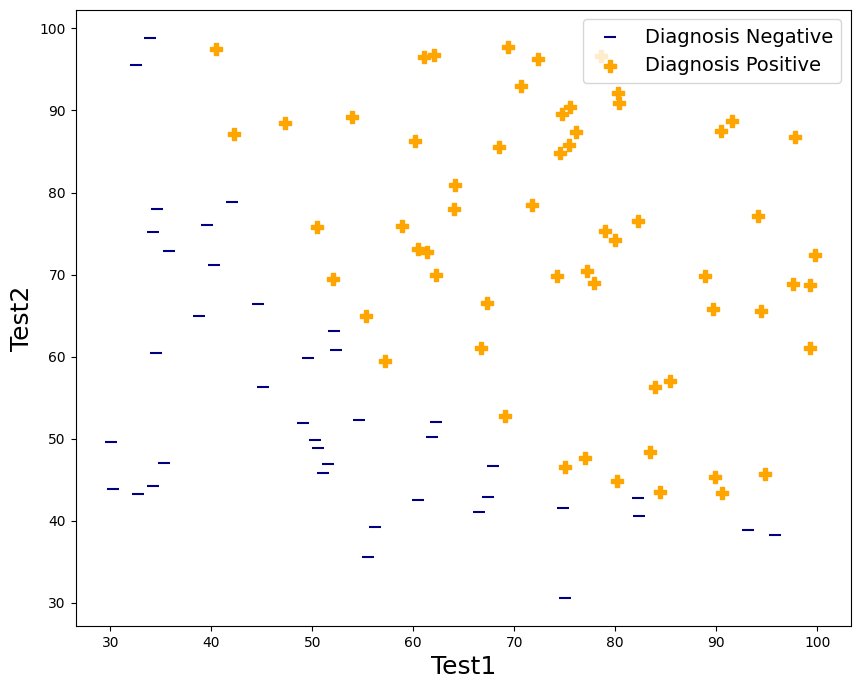

In [136]:
data = pd.read_csv('data/labtests.csv')
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

plot_twoclass_data(X,y,data.columns[0], data.columns[1],['Diagnosis Negative', 'Diagnosis Positive'])


# Unregularized logistic regression

In [138]:
class LogisticRegression(nn.Module):  
    """The logistic regression model."""
    def __init__(self, num_inputs, lr):
        super().__init__()
        self._lr = lr
        self.net = nn.Linear(num_inputs,1)
        self.net.weight.data.normal_(0,0.01)
        self.net.bias.data.fill_(0)

    def forward(self, X):
        return self.net(X)
    
    def loss(self, yhat, y):
        criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
        return criterion(yhat,y)
    
    def predict(self,X):
        return torch.sigmoid(self.net(X))
    
    def configure_optimizers(self):
        return torch.optim.LBFGS(self.parameters(),self._lr)

torch.Size([100, 2]) torch.Size([100, 1])


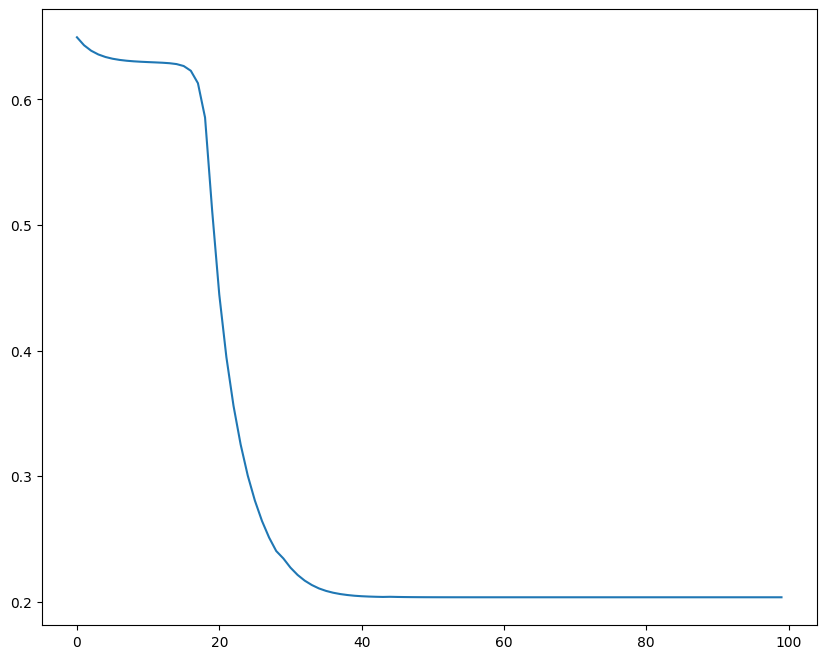

In [139]:
# convert X, y to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y).reshape((-1,1))
print(X.shape, y.shape)

# hyperparameters
lr = 0.001
num_epochs = 100

# initialize and train the model
model = LogisticRegression(2,0.01)

def train_model(model,X,y,num_epochs):
    
    train_loss = torch.zeros((num_epochs,))
    optimizer = model.configure_optimizers()
    for epoch in range(num_epochs):
        def closure():
            optimizer.zero_grad()
            output = model.forward(X)
            loss = model.loss(output, y)
            loss.backward()
            return loss
    
        optimizer.step(closure)
        loss = closure()
        train_loss[epoch] = loss.item()
    return model, train_loss

model,train_loss = train_model(model,X,y,num_epochs)
plt.plot(torch.arange(num_epochs),train_loss)

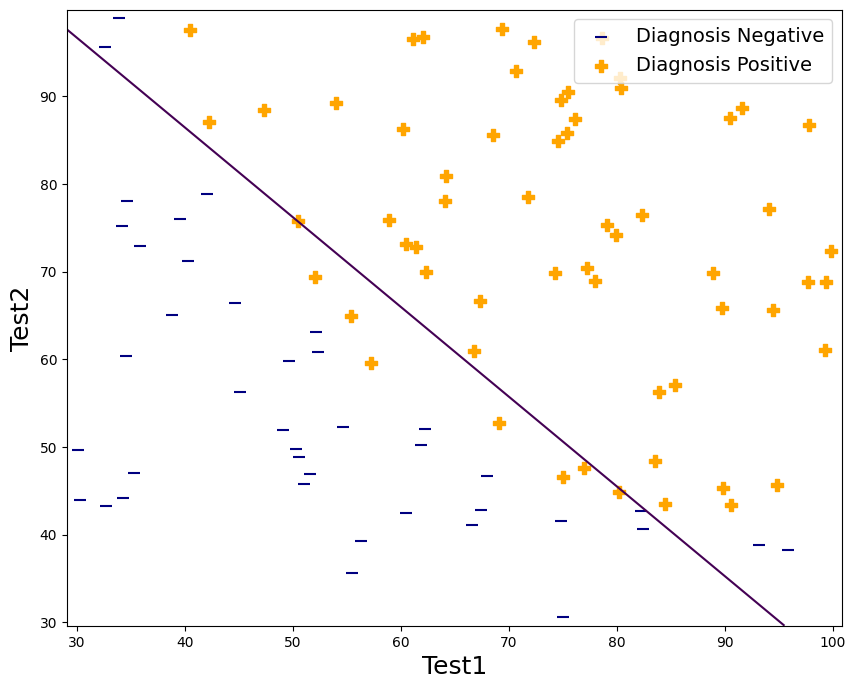

In [140]:
plot_decision_boundary_logistic(X,y,model,  'Test1', 'Test2',['Diagnosis Negative', 'Diagnosis Positive'])

# L2 Regularized logistic regression with basis function expansion

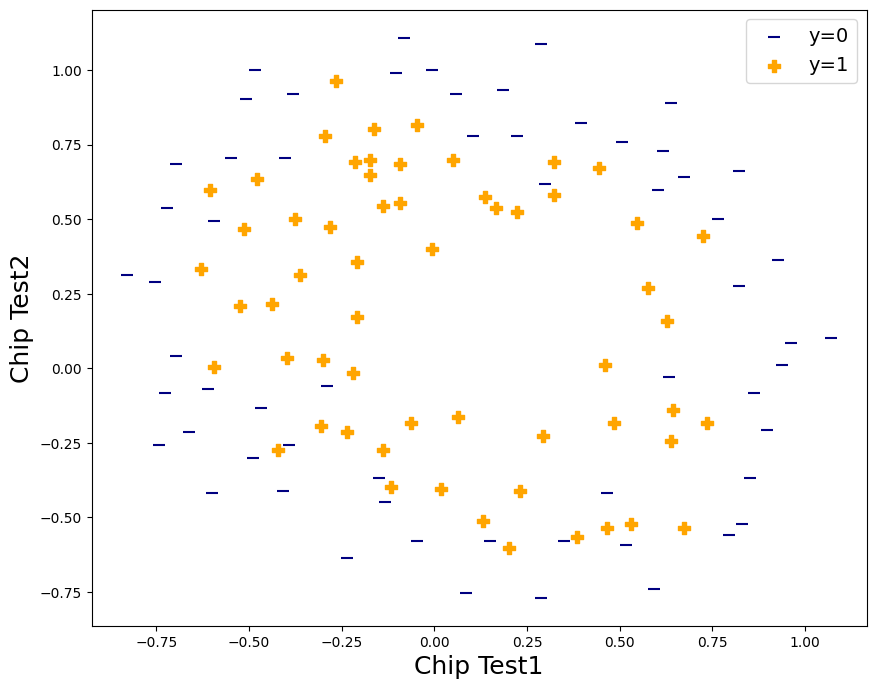

In [141]:
data = pd.read_csv('data/chipdata.csv')
X = torch.Tensor(data.iloc[:,:2].values)
y = torch.Tensor(data['y'].values).type('torch.FloatTensor')

plot_twoclass_data(X,y,'Chip Test1', 'Chip Test2',['y=0','y=1'])

# Expanding basis function and regularizing logistic regression

In [142]:
class L2LogisticRegression(nn.Module):
    """
    Logistic Regression with explicit L2 regularization.
    """

    def __init__(self, num_features, lr, reg=0.0):
        super().__init__()
        self.net = nn.Linear(num_features, 1)   # single logit output
        self._lr = lr
        self._reg = reg

    def forward(self, X):
        """
        Forward pass: returns raw logits (before sigmoid).
        """
        return self.net(X)

    def predict_proba(self, X):
        """
        Return probability for class=1.
        """
        return torch.sigmoid(self.forward(X))

    def predict(self, X, threshold=0.5):
        """
        Return binary predictions {0,1}.
        """
        probs = self.predict_proba(X)
        return (probs >= threshold).long()

    def loss(self, yhat, y):
        """
        Compute BCE loss with L2 penalty.
        yhat: raw logits from forward()
        y: targets (0/1), shape (N,1) or (N,)
        """
        # Binary cross-entropy with logits
        criterion = nn.BCEWithLogitsLoss()
        base_loss = criterion(yhat, y.view(-1,1).float())

        # L2 penalty (exclude bias term)
        l2_penalty = sum(torch.norm(p, 2).pow(2) for name, p in self.named_parameters() if 'bias' not in name)

        return base_loss + self._reg * l2_penalty

    def configure_optimizers(self):
        return torch.optim.LBFGS(self.parameters(),self._lr)

In [143]:
poly = PolynomialFeatures(degree = 3,include_bias=False)
Xpoly = torch.Tensor(poly.fit_transform(X))
features = poly.get_feature_names_out()
y = y.reshape((-1,1))

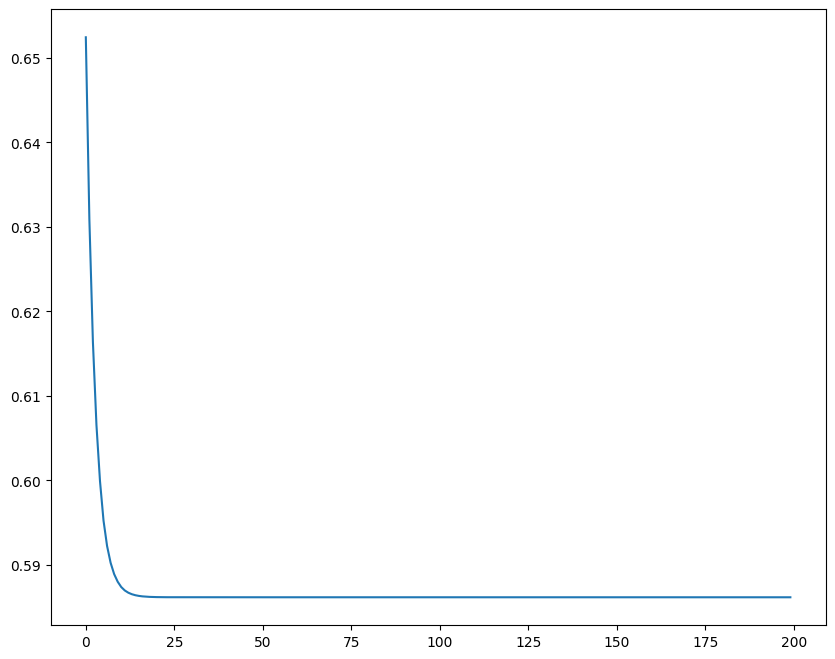

In [144]:
lr = 0.01
reg = 0.005
num_epochs = 200

model = L2LogisticRegression(Xpoly.shape[1],lr,reg)
model,train_loss = train_model(model,Xpoly,y,num_epochs)
plt.plot(torch.arange(num_epochs),train_loss)

In [145]:
def plot_decision_boundary_model_poly(X,y,model,poly, xlabel, ylabel, legend):
    plot_twoclass_data(X,y.squeeze(),xlabel,ylabel,legend)
    
    # create a mesh to plot in
    h = 0.01
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                         np.arange(x2_min, x2_max, h))

    # do basis function expansion before prediction
    
    
    
    
    Z = model.predict(torch.Tensor(poly.transform(np.vstack([xx1.flatten(), xx2.flatten()]).T))).detach().numpy()
   
    
   
    # Put the result into a color contour plot
    Z = Z.reshape(xx1.shape)
    
    plt.contour(xx1,xx2,Z,cmap=plt.cm.gray,levels=[0.5])
    plt.title("Decision boundary for lambda = " + str(model._reg),fontsize=16)


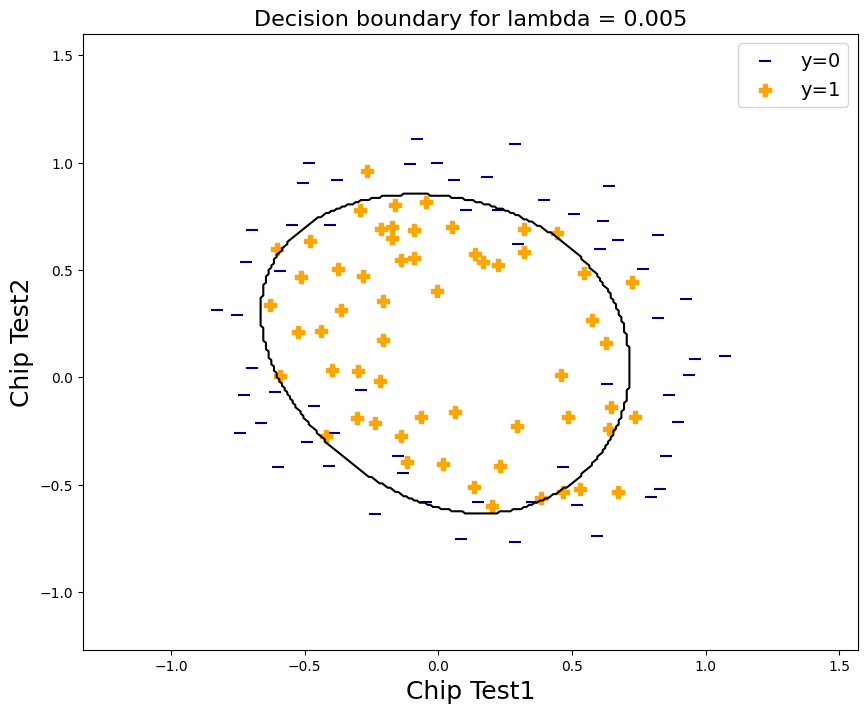

In [146]:
plot_decision_boundary_model_poly(X,y,model,poly,'Chip Test1', 'Chip Test2',['y=0','y=1'])

# Experimenting with the regularization lambda (wd)
- try values of 0.001, 0.01, 0.1, 1.0, 10.0
- plot the decision boundaries with these values

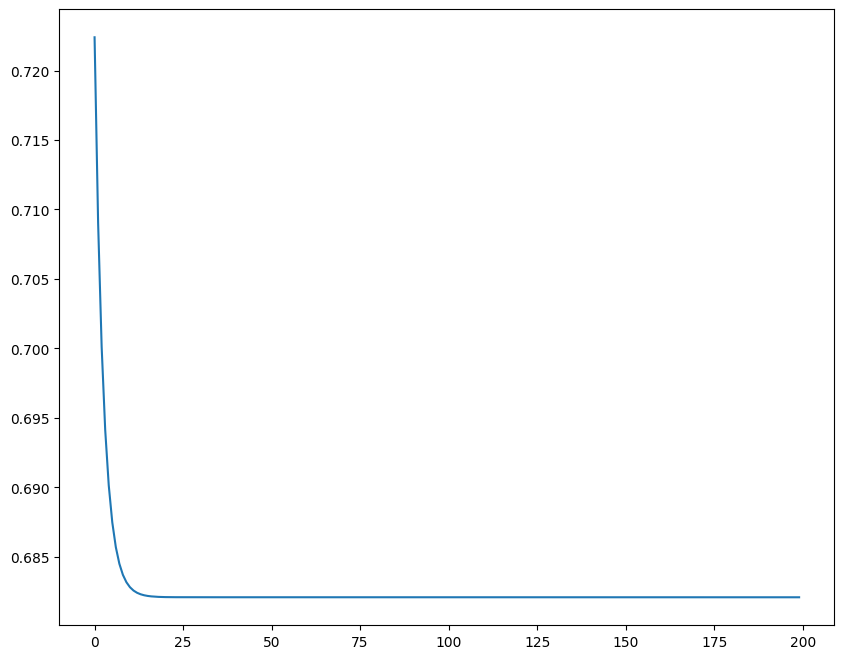

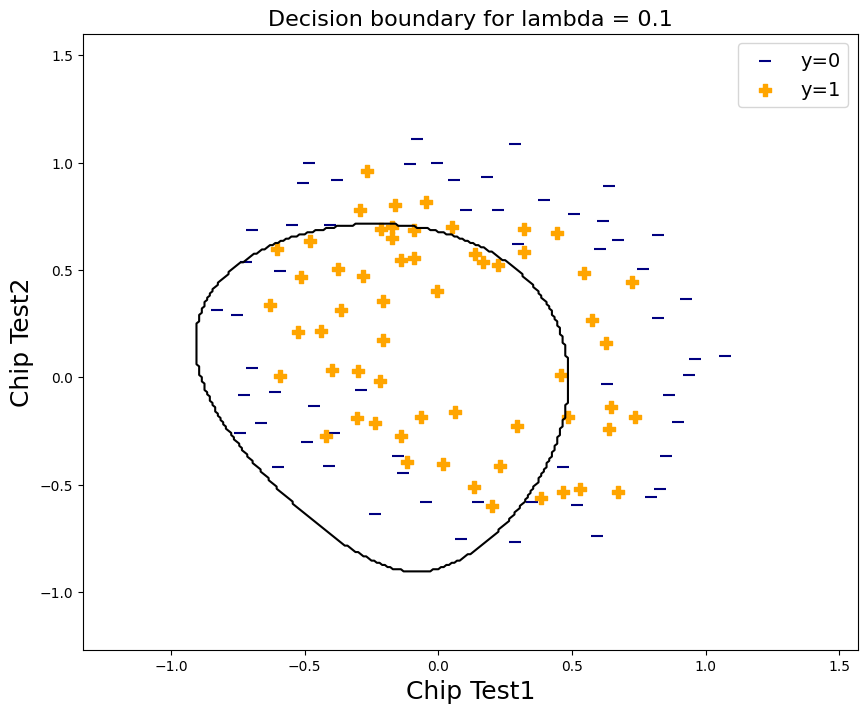

In [147]:
reg = 0.1
model = L2LogisticRegression(Xpoly.shape[1],lr,reg)
model,train_loss = train_model(model,Xpoly,y,num_epochs)
plt.plot(torch.arange(num_epochs),train_loss)

plot_decision_boundary_model_poly(X,y,model,poly,'Chip Test1', 'Chip Test2',['y=0','y=1'])
    

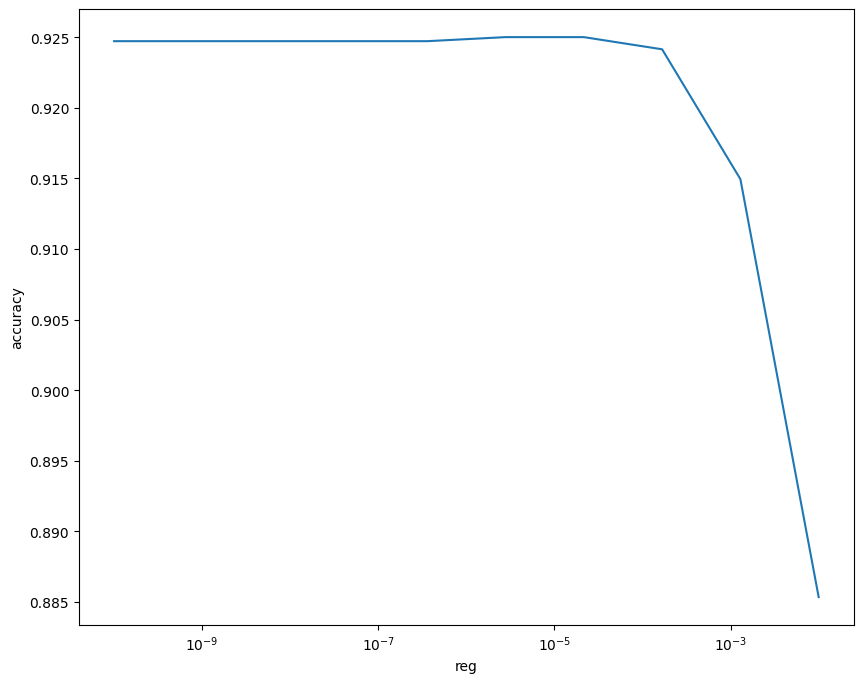

In [152]:
# selecting alpha 
n_regs = 10
regs = torch.logspace(-10,-2,n_regs)
scores = []
for reg in regs:
    poly = PolynomialFeatures(degree = 3,include_bias=False)
    Xpoly = torch.Tensor(poly.fit_transform(X))
    model = L2LogisticRegression(Xpoly.shape[1],lr,reg)
    model,train_loss = train_L2model(model,Xpoly,y,num_epochs)
    ypred = model.predict_proba(Xpoly).detach().numpy()
    acc = sklearn.metrics.roc_auc_score(y,ypred)
    scores.append(acc)
    
plt.semilogx(regs,scores)
plt.xlabel('reg')
plt.ylabel('accuracy');


Best lambda =  tensor(2.1544e-05)


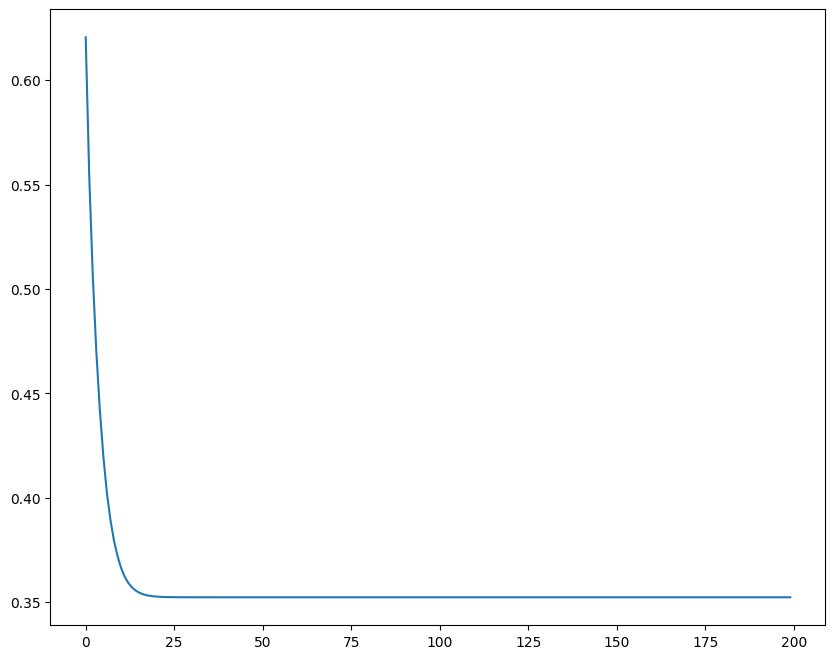

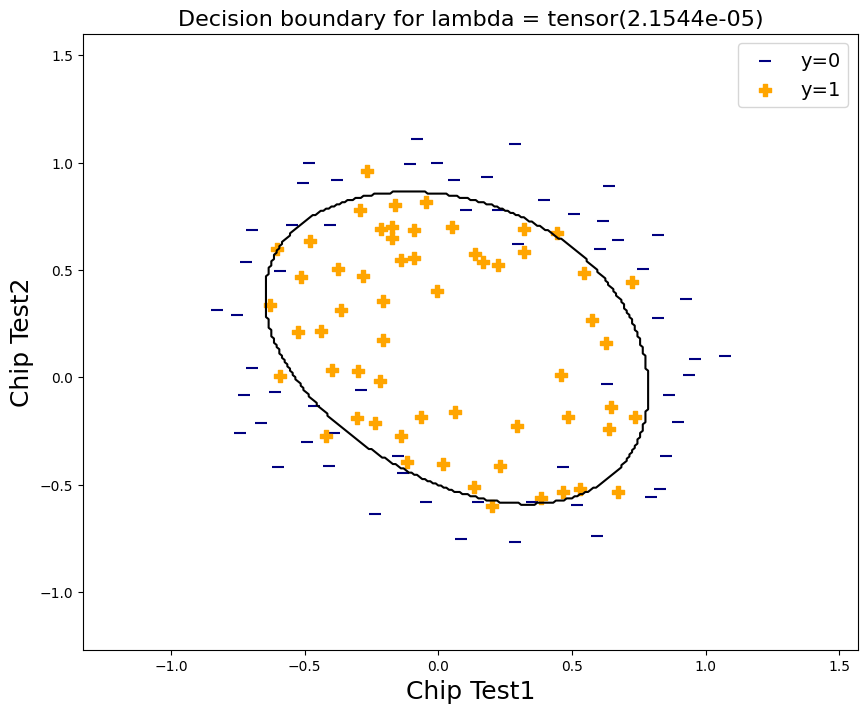

In [154]:
# build with best scores

reg = regs[scores.index(max(scores))]
print('Best lambda = ',reg)
model = L2LogisticRegression(Xpoly.shape[1],lr,reg)
model,train_loss = train_L2model(model,Xpoly,y,num_epochs)
plt.plot(torch.arange(num_epochs),train_loss)

plot_decision_boundary_model_poly(X,y,model,poly,'Chip Test1', 'Chip Test2',['y=0','y=1'])
    

# Logistic regression with L1 norm

In [174]:
class L1LogisticRegression(nn.Module):
    """
    Logistic Regression with explicit L1 regularization.
    """

    def __init__(self, num_features, lr,reg=0.0):
        super().__init__()
        self.net = nn.Linear(num_features, 1)   # single logit output
        self._lr = lr
        self._reg = reg

    def forward(self, X):
        """
        Forward pass: returns raw logits (before sigmoid).
        """
        return self.net(X)

    def predict_proba(self, X):
        """
        Return probability for class=1.
        """
        return torch.sigmoid(self.forward(X))

    def predict(self, X, threshold=0.5):
        """
        Return binary predictions {0,1}.
        """
        probs = self.predict_proba(X)
        return (probs >= threshold).long()

    def loss(self, yhat, y):
        """
        Compute BCE loss with L1 penalty.
        yhat: raw logits from forward()
        y: targets (0/1), shape (N,1) or (N,)
        """
        # Binary cross-entropy with logits
        criterion = nn.BCEWithLogitsLoss()
        base_loss = criterion(yhat, y.view(-1,1).float())

        # L1 penalty (exclude bias term)
        l1_penalty = sum(p.abs().sum() for name, p in self.named_parameters() if 'bias' not in name)

        return base_loss + self._reg * l1_penalty

    def configure_optimizers(self):
        return torch.optim.LBFGS(self.parameters(),self._lr)

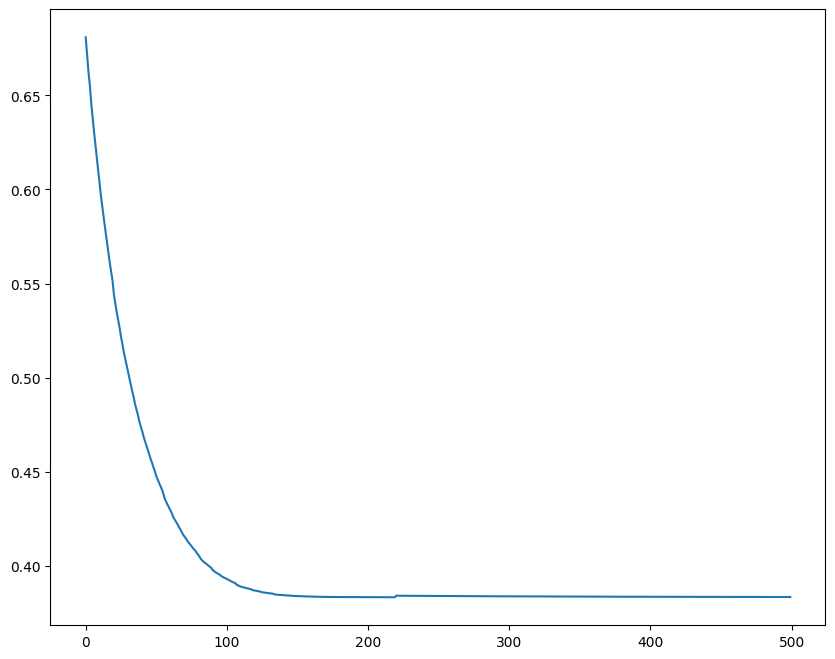

In [188]:
y = y.reshape((-1,1))

lr = 0.001
reg = 0.001
num_epochs = 500

model = L1LogisticRegression(Xpoly.shape[1],lr,reg)
model,train_loss = train_model(model,Xpoly,y,num_epochs)
plt.plot(torch.arange(num_epochs),train_loss)

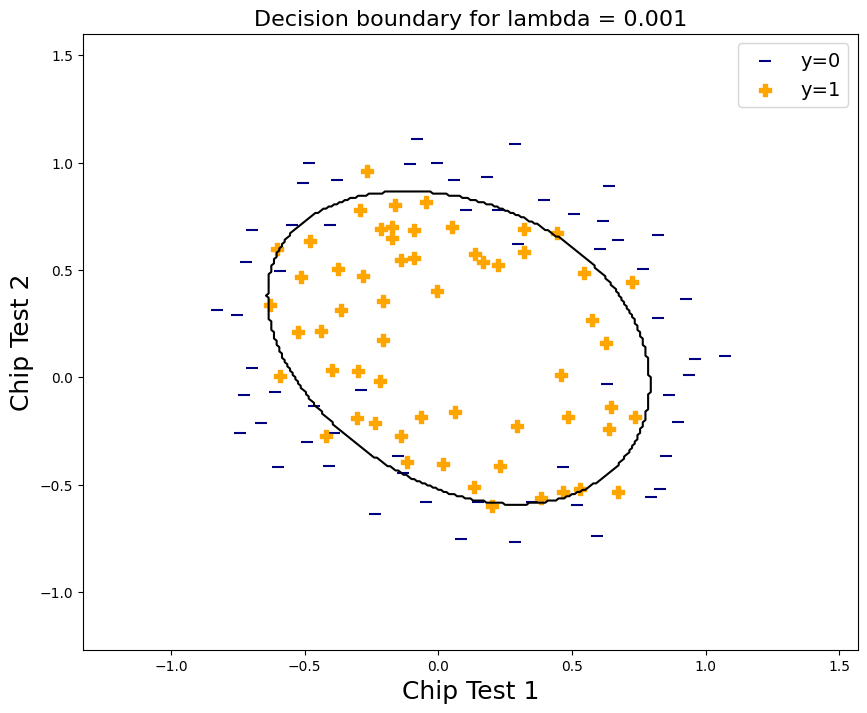

In [189]:
plot_decision_boundary_model_poly(X,y,model,poly,'Chip Test 1', 'Chip Test 2',['y=0','y=1'])